In [1]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time

# Loading the data

In [2]:
Root_dir = "D:/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "D:/New Plant Diseases Dataset(Augmented)/test"
Diseases_classes = os.listdir(train_dir)

# Moving training to GPU

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(Root_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Setting up the model

## Classification Base

Let's create a step by step classification base module:

First, Training_step: the images and labels take values from batch. The output of model is a type of images and the loss is calculate from F cross entropy function (out, labels). It seems that the prediction is compared with the actual values in labels.

Second, validation step: is just like the above one. But it has another attribute call acc.

Third, validation_epoch_end: calculate the losses and acces of each batchs and epochs.

Fourth, epoch_end: That shows the final results of everything.

## Model

Connecting the model to use a GPU

In [4]:
# defining the model and moving it to the GPU
# model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model_ft = torchvision.models.resnet18(weights='DEFAULT')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

## Model Eval / Optimisation

## Model Training

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    results = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pth')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                results.append({phase:{"loss":epoch_loss, "acc":epoch_acc}})
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, results

In [6]:
num_epoch = 5
lr_rate = 0.01
weight_decay = 1e-4
optims = torch.optim.Adam

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

model_ft, results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epoch)

Epoch 0/4
----------
train Loss: 2.2521 Acc: 0.3635
valid Loss: 0.8240 Acc: 0.7432

Epoch 1/4
----------
train Loss: 0.7543 Acc: 0.7648
valid Loss: 0.4113 Acc: 0.8671

Epoch 2/4
----------
train Loss: 0.3830 Acc: 0.8800
valid Loss: 0.1493 Acc: 0.9516

Epoch 3/4
----------
train Loss: 0.3179 Acc: 0.8984
valid Loss: 0.1306 Acc: 0.9553

Epoch 4/4
----------
train Loss: 0.2860 Acc: 0.9097
valid Loss: 0.1064 Acc: 0.9649

Training complete in 12m 23s
Best val Acc: 0.964887


In [7]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_ft.state_dict():
    print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

In [8]:
torch.save(model_ft.state_dict(), "data/resnet18/resnet18_nodecay_model.pth")

# Results

In [9]:
val_acc = []
val_loss = []
train_loss = []

for i in results:
    # train_loss.append(i['train']['loss'])
    for k, v in i.items():
        if k == 'train':
            train_loss.append(v['loss'])
        else:
            val_acc.append(float(f"{v['acc']:.4f}"))
            val_loss.append(v['loss'])    

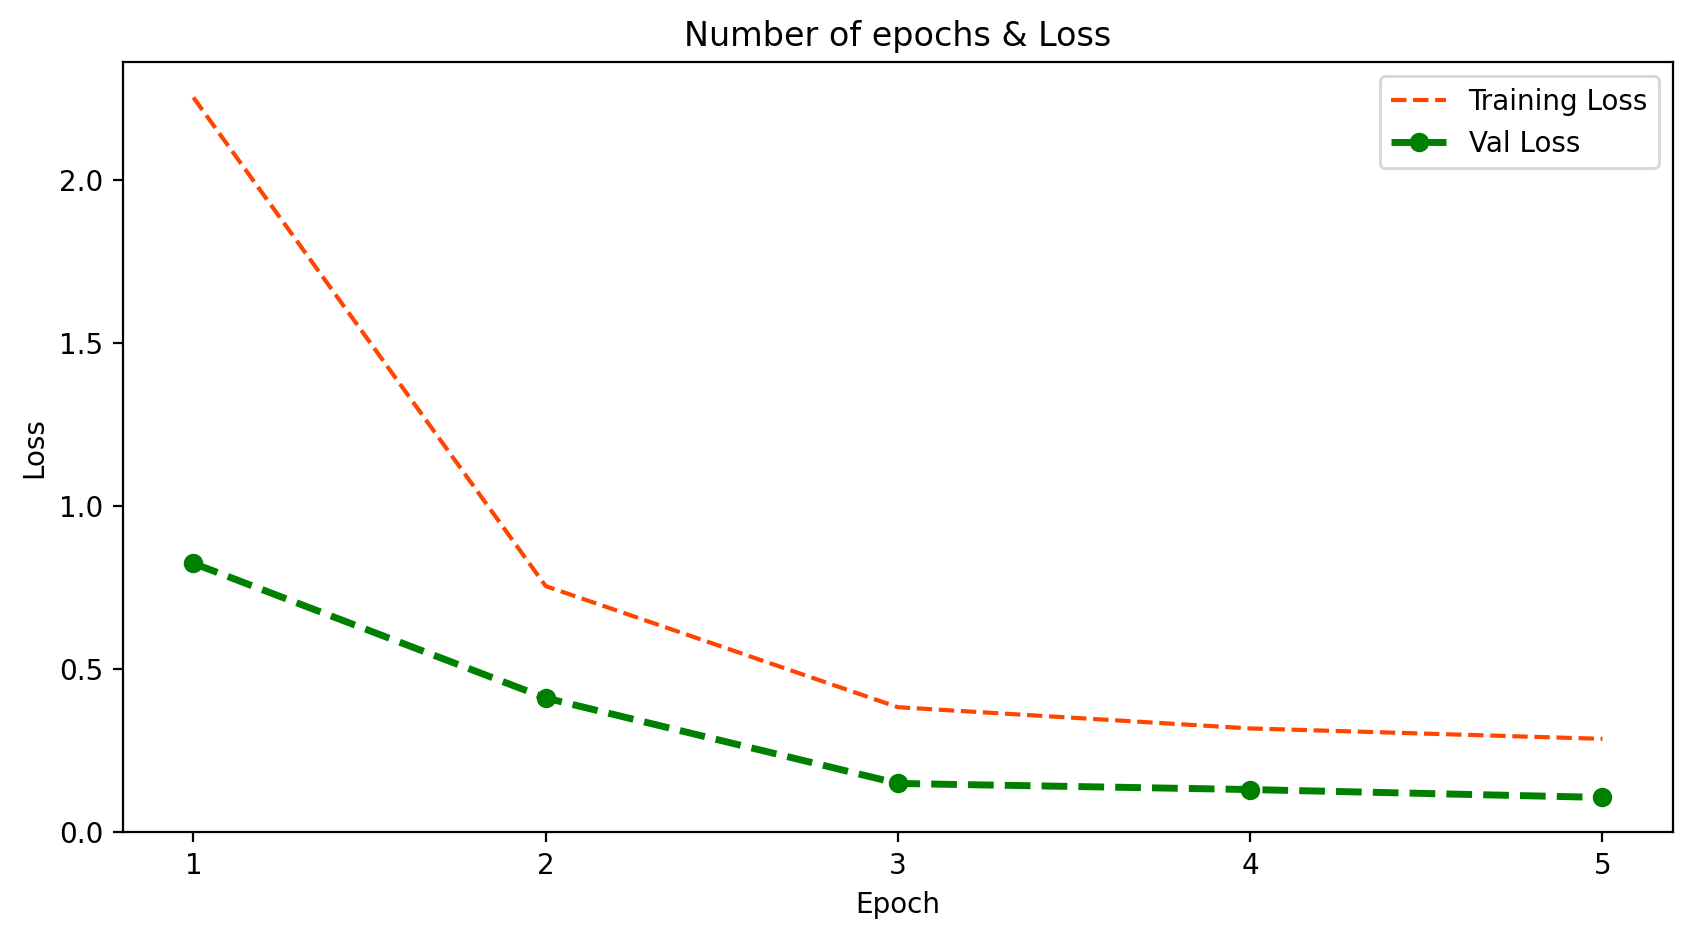

In [10]:
epoch_count = range(1,6)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'orangered')
plt.plot(epoch_count, val_loss, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,6,1))
plt.show();

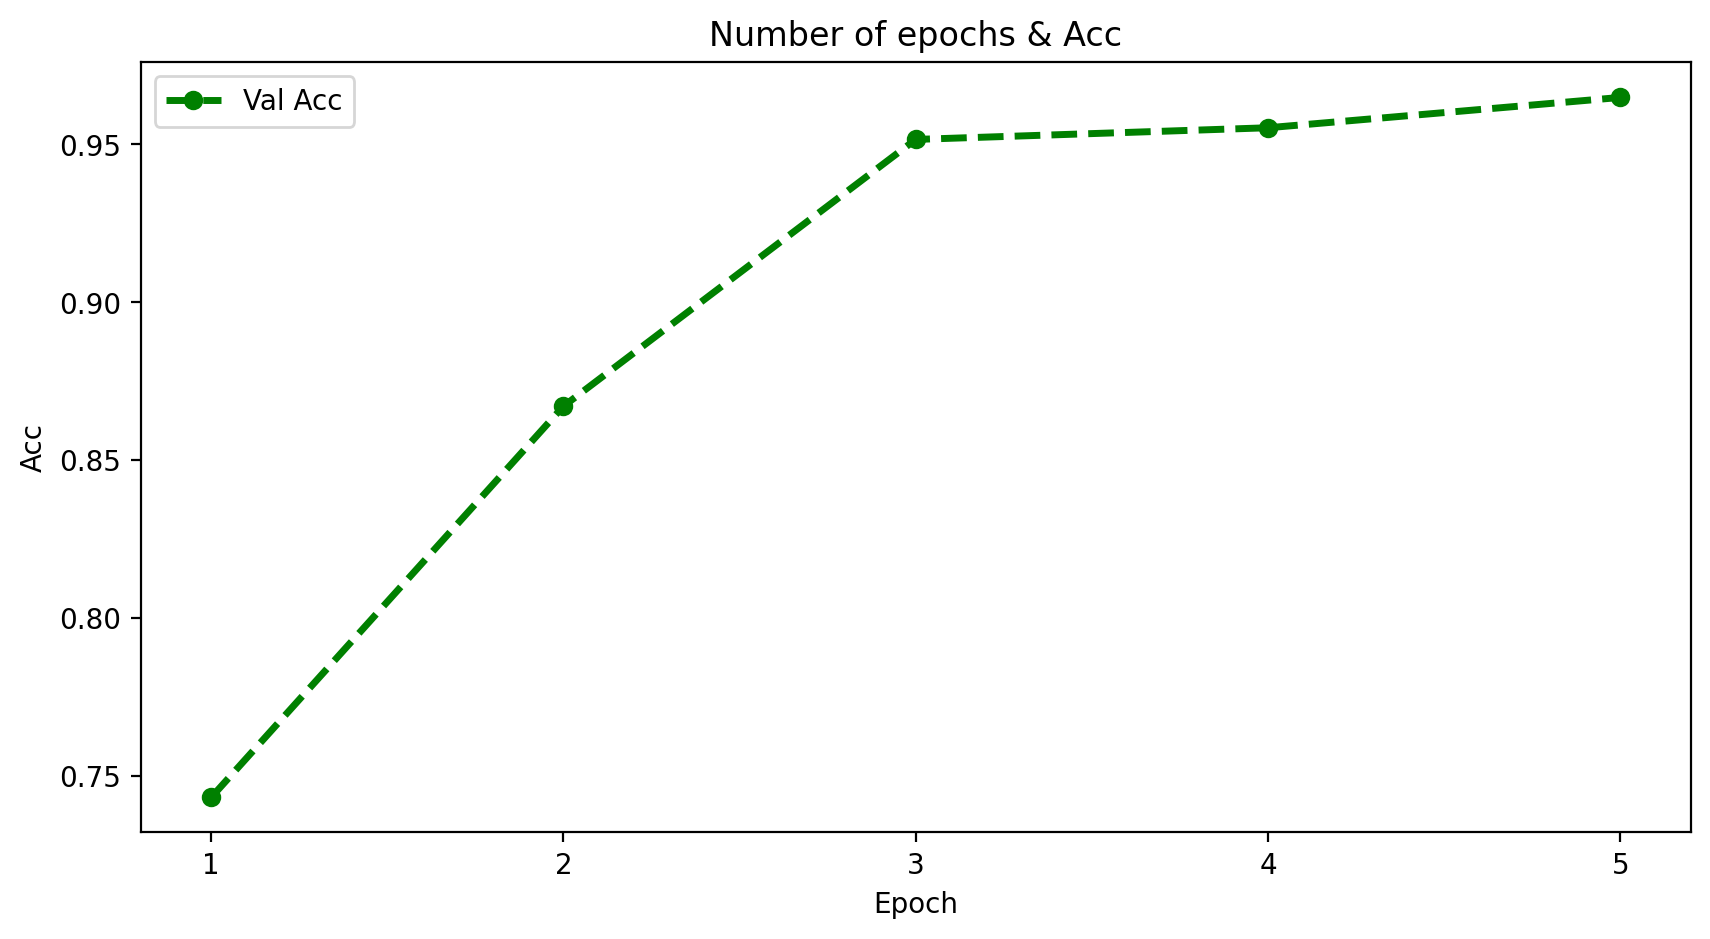

In [11]:
epoch_count = range(1,6)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Val Acc'])
plt.title('Number of epochs & Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,6,1))
plt.show();

## Test Data

In [12]:
# test = datasets.ImageFolder(test_dir, transform=torchvision.transforms.ToTensor())
# test_images = sorted(os.listdir(test_dir + '/test'))
# print(test_images)
# print(len(test_images))

In [13]:
# def predict_image(img, model):
#     """Converts image to array and return the predicted class
#         with highest probability"""
#     # Convert to a batch of 1
#     # xb = to_device(img.unsqueeze(0), device)
#     xb = img.unsqueeze(0).to(device)
#     # Get predictions from model
#     yb = model(xb)
#     # Pick index with highest probability
#     _, preds  = torch.max(yb, dim=1)
#     # Retrieve the class label

#     return class_names[preds[0].item()]

In [14]:
# # predicting first image
# cur_test = 0
# img, label = test[cur_test]
# plt.imshow(img.permute(1, 2, 0))
# print('Label:', test_images[cur_test], ', Predicted:', predict_image(img, model_ft))

In [15]:
# for i in range(len(test_images)):
#     img, label = test[i]
#     print('Label:', test_images[i], ', Predicted:', predict_image(img, model_ft))